In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
    
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [50]:
# load dataset
dataset = read_csv('T1'+'.csv', header=0, index_col=0)
values = dataset.values

# specify the number of lag and ahead hours
n_hours = 24
n_ahead = 2
n_features = 4

# integer encode direction
#encoder = LabelEncoder()
#values[:,n_features-1] = encoder.fit_transform(values[:,n_features-1])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#print(scaled)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours,n_ahead, 1)
#print(reframed)
print(reframed.shape)

(50505, 104)


In [51]:
# split into train and test sets
values = reframed.values
n_train_hours = (int)(len(dataset)*0.6)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

#print(train)

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

#print(train_X)
#print(train_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(30318, 96) 30318 (30318,)
(30318, 24, 4) (30318,) (20187, 24, 4) (20187,)


In [52]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [53]:
# fit network
history = model.fit(train_X, train_y, epochs=2, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
model.save("WindBot.h5")

Train on 30318 samples, validate on 20187 samples
Epoch 1/2
 - 47s - loss: 0.0945 - val_loss: 0.0731
Epoch 2/2
 - 45s - loss: 0.0672 - val_loss: 0.0675


In [54]:
model = load_model('WindBot.h5')

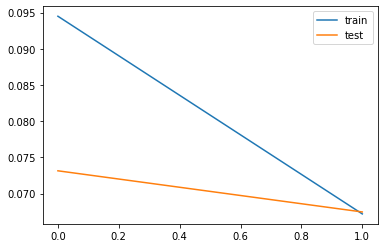

In [55]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#print(inv_yhat)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#print(inv_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[3378.9194 3376.029  3349.5703 ... 3247.0857 2625.7417 2542.1667]
[3211.54  3152.919 3318.183 ... 2201.107 2515.694 2820.466]
Test RMSE: 354.183


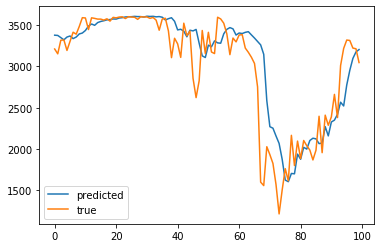

In [59]:
# plot history
pyplot.plot(inv_yhat[0:100], label='predicted')
pyplot.plot(inv_y[0:100], label='true')
pyplot.legend()
pyplot.show()

In [ ]:
#custom test file
